<img src="./Data/parabolic-3d.png" style="zoom:50%;" />

# Import

In [ ]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=b6edb512a11c22b95d8e8531dd662852c8b32a07013e6c268ae111a0500dbe0d
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp #TFP needs TF>= 2.3
import time

tf.random.set_seed(1234)
np.random.seed(1234)

# Setting

In [ ]:

x = symbols('x')
y = symbols('y')
z = symbols('z')
t = symbols('t')

a = v1 = v2 = k =1.0 # or a=4 ,v1=5 ,v2=10 ,k=1/4
c1 = 1 + v1/k ;c2 = -v1/v2;c3 = c2 - c1
g1 = g2 =0

u1 = a*x*y*(1-x)*(1-y)*(1-z)*exp(-t)
u2 = a*x*y*(1-x)*(1-y)*(c1 + c2*z + c3*z**2)*exp(-t)

f1 = diff(u1,t) - v1*( diff(u1,x,2) + diff(u1,y,2) + diff(u1,z,2))
f2 = diff(u2,t) - v2*( diff(u2,x,2) + diff(u2,y,2) + diff(u2,z,2))

u1 = lambdify((x,y,z,t),u1)
u2 = lambdify((x,y,z,t),u2)

f1 = lambdify((x,y,z,t),f1,'tensorflow')
f2 = lambdify((x,y,z,t),f2,'tensorflow')

# TrainingData & TestData

In [ ]:
def trainingdata(N_u,N_i,N_f,omga,u,interface,regions):    
    '''
      若interface = 0, 则z_range[0] 作为 interface ; 若interfacer = 1 则 z_range[1]作为interface
    '''  
    x_range = omga[0]
    y_range = omga[1]
    z_range = omga[2]
    t_range = [0.,1.]

    all_X_u_train = []
    all_u_train = []

    # Initial Condition t=0 
    lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[1],t_range[0]])
    initial_X = lb + (ub-lb)*lhs(4,N_u)
    initial_u = u(initial_X[:,0], initial_X[:,1], initial_X[:,2],initial_X[:,3]).reshape(-1,1)
    
    all_X_u_train.append(initial_X)
    all_u_train.append(initial_u)
    
    # 
    regions_x = regions[0]
    regions_y = regions[1]
    regions_z = regions[2]
    num_regions = len(regions_x)*len(regions_y)*len(regions_z)
    for sub_x_range in regions_x:
      for sub_y_range in regions_y:
        for sub_z_range in regions_z:
          lb = np.array([sub_x_range[0],sub_y_range[0],sub_z_range[0],t_range[0]])
          ub = np.array([sub_x_range[1],sub_y_range[1],sub_z_range[1],t_range[1]])
          region_X = lb + (ub-lb)*lhs(4,int(N_u/num_regions))
          region_u = u(region_X[:,0],region_X[:,1],region_X[:,2],region_X[:,3]).reshape(-1,1)

          all_X_u_train.append(region_X)
          all_u_train.append(region_u)  


    all_X_u_train =  np.vstack(all_X_u_train)
    all_u_train = np.vstack(all_u_train)
    
    idx = np.random.choice(all_X_u_train.shape[0],all_X_u_train.shape[0], replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:] 

    # BC_interface: x2 = x2_range[interface], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    lb = np.array([x_range[0],y_range[0],z_range[interface],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[interface],t_range[1]])
    X_i_train = lb + (ub-lb)*lhs(4,N_i) 

           
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y,z,t)
    lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(4,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points
    
    return X_u_train,u_train,X_f_train,X_i_train

def ds_train_n_batch(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)
    batch_f1 = int(len(X_f1_train)/n)

    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)
    batch_f2 = int(len(X_f2_train)/n)
    
    batch_i = int(len(X_i_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    ds_f1 = tf.data.Dataset.from_tensor_slices( X_f1_train ).batch( batch_f1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    ds_f2 = tf.data.Dataset.from_tensor_slices( X_f2_train ).batch( batch_f2 )
    
    ds_i = tf.data.Dataset.from_tensor_slices(X_i_train).batch(batch_i)

    ds_train = tf.data.Dataset.zip((ds_u1,ds_f1,ds_u2,ds_f2,ds_i))
    return ds_train

def ds_test_n_batch(x1_test,u1_test,x2_test,u2_test,n=5):
  batch_u1 = int(len(u1_test)/n)
  batch_u2 = int(len(u2_test)/n)

  ds_u1 = tf.data.Dataset.from_tensor_slices( (x1_test,u1_test) ).batch(batch_u1)
  ds_u2 = tf.data.Dataset.from_tensor_slices( (x2_test,u2_test) ).batch(batch_u2)

  ds_test = tf.data.Dataset.zip((ds_u1,ds_u2))
  return ds_test
  
def test_data(N,omga,u):
  x_range = omga[0]
  y_range = omga[1]
  z_range = omga[2]
  t_range = [0.,1.]

  lb = np.array([x_range[0],y_range[0],z_range[0],t_range[1]])
  ub = np.array([x_range[1],y_range[1],z_range[1],t_range[1]])
  x_test = lb + (ub-lb)*lhs(4,N)
  u_test = u(x_test[:,0],x_test[:,1],x_test[:,2],x_test[:,3]).reshape((-1,1)) 

  return x_test,u_test

# Plot 

In [ ]:
omga1 = [[0.,1.],[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[0.,1.],[-1.,0.]] 
def plot_real_data(N,omga,u,t=1.0):
  # Output: X,Y,T,U shape=(N,N)
  x_range = tf.linspace(omga[0][0],omga[0][1],N)
  y_range = tf.linspace(omga[1][0],omga[1][1],N)
  z_range = tf.linspace(omga[2][0],omga[2][1],N)

  X,Y,Z = tf.meshgrid(x_range,y_range,z_range)
  T = tf.ones(shape=X.shape)*t
  U = u(X,Y,Z,T)
  return X,Y,Z,T,U

def plot_pred_data(X,Y,Z,T,model):
  #Input: X,Y,Z,T shape=(N,N)
  #Output: U_pred shape=(N,N)
  Shape = X.shape
  dim = len(Shape)
  X = tf.reshape(X,shape=(Shape[0]**dim,1))
  Y = tf.reshape(Y,shape=(Shape[0]**dim,1))
  Z = tf.reshape(Z,shape=(Shape[0]**dim,1))
  T = tf.reshape(T,shape=(Shape[0]**dim,1))

  Inputs = tf.concat([X,Y,Z,T],axis=1)
  U_pred = model(Inputs)
  U_pred = tf.reshape(U_pred,shape=Shape)
  return U_pred



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyparsing import col
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math

In [ ]:
def set_axes3D(axes:Axes3D,title:str):
    """设置 axes 的格式

    Args:
        axes (Axes3D): _description_
        title (str): _description_
    """
    #axes.set_box_aspect((3,1,3)) # 坐标轴缩放比例
    axes.set_xlim(0,1) #坐标轴范围
    axes.set_ylim(0,1)
    #axes.set_zlim(0,1)
    axes.set_xlabel('$x$',fontsize = 15, labelpad=-8.0) # 设置坐标轴标签
    axes.set_ylabel('$y$',fontsize = 15, labelpad=-3.0)
    axes.set_zlabel('$z$',fontsize = 15, labelpad= 2.0)
    axes.view_init(elev=30, azim=75) # 观察视角
    axes.tick_params(
        axis = 'x',
        which = 'major',
        pad = -4.5
    ) # 特殊设置，坐标轴标签位置调整
    axes.tick_params(
        axis = 'y',
        which = 'major',
        pad = -2.0
    )
    axes.tick_params(
        axis = 'both',
        which = 'major',
        direction = 'out',
        length = 1.0, 
        labelsize = 'small', #刻度标签的文字大小
    )
    # axes.xaxis.set_major_formatter('{x:.1f}s') # 还是不加单位了
    # axes.locator_params('x',nbins = 1,tight=True)
    axes.set_title(title,fontsize = 15) # 子图标题


In [ ]:
def plot3D_scatter(data_dict,colN = 4):
    
    figN = len(data_dict)
    rowN = math.ceil(figN /colN)
    
    subsize = [4.5,3] # 宽 高
    fig = plt.figure(figsize=(subsize[0] * colN, subsize[1] * rowN))

    for i,(key,datas) in enumerate(data_dict.items()):
        axes:Axes3D = fig.add_subplot(rowN, colN, i+1, projection='3d')
        set_axes3D(axes,key)
        img = axes.scatter(datas[0],datas[1],datas[2],
                           c = datas[3],
                           s=3,
                           cmap=plt.get_cmap('RdYlBu_r'),#'RdYlBu_r' 
                           alpha=0.8)

        fig.colorbar(img,ax=axes, shrink=0.6, format='%.2f')
        
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
    return fig

In [ ]:
def plot_Adam_history(history_saw_cp,start_epoch=0.05):

  fig = plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(211)
  epoches = len(history_saw_cp.history['loss'])
  start = int(epoches*start_epoch)
  x = np.arange(start,epoches,1)

  line1, = ax1.plot(x,history_saw_cp.history['loss'][start:],'g:')
  line2, = ax1.plot(x,history_saw_cp.history['loss_u1'][start:],'r:')
  line3, = ax1.plot(x,history_saw_cp.history['loss_u2'][start:],'b:')
  ax1.legend(handles=[line1,line2,line3],labels=['loss','loss_u1','loss_u2'])
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoches')
  ax1.autoscale()

  ax2 = fig.add_subplot(212)
  line4, = ax2.plot(x,history_saw_cp.history['val_err_u1'][start:],'r:')
  line5, = ax2.plot(x,history_saw_cp.history['val_err_u2'][start:],'b:')
  ax2.legend(handles=[line4,line5],labels=["err_u1","err_u2",])
  ax2.set_ylabel("error_rate")
  ax2.set_xlabel("epochs")
  ax2.autoscale()
  fig.suptitle("Adam")

  plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
  plt.show()

  fig.savefig("3d_parabolic_Adam_history.png")
  return fig

In [ ]:
def plot_Lbfgs_history(histroy,max_iterations):

  fig_lbfgs,ax = plt.subplots()
  ax.plot(histroy,'b:')
  ax.set_xlabel("num_objective_evaluations")
  ax.set_ylabel("loss")
  ax.set_title("L-BFGS Max_Iterations={}".format(max_iterations))
  
  plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
  plt.show()

  fig_lbfgs.savefig("3d_parabolic_lbfgs_history.png")
  return fig_lbfgs

# PINN Model

## Single PINN

In [ ]:
class MyPinn(keras.Sequential): 
    def __init__(self,Layers,v,n,f,name = None): 
        super(MyPinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],) ,dtype=tf.float64))
        for i in range(1,len(Layers)-1):
            self.add(keras.layers.Dense(Layers[i], dtype=tf.float64,
                #kernel_regularizer=keras.regularizers.l2(0.01), 
                #activity_regularizer=keras.regularizers.l1(0.01), 
                activation='tanh'))
        self.add(keras.layers.Dense(Layers[-1],dtype=tf.float64, name="outputs"))
        self.v = tf.constant(v,dtype=tf.float64)
        self.n = tf.constant(n,dtype=tf.float64)
        self.f = f
 

    @tf.function
    def loss_U(self,X_u_train,u_train):
        u= self(X_u_train)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u
    #   
    @tf.function
    def loss_PDE(self,X_f_train):
        x = X_f_train[:,0:1]
        y = X_f_train[:,1:2]
        z = X_f_train[:,2:3]
        t = X_f_train[:,3:4]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x,y,z,t])
            X = tf.stack([x[:,0],y[:,0],z[:,0],t[:,0]],axis=1)
            u = self(X)  
            u_x = tape.gradient(u,x)
            u_y = tape.gradient(u,y)
            u_z = tape.gradient(u,z)
               
        u_t = tape.gradient(u, t)     
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
        u_zz = tape.gradient(u_z, z)

        del tape
      
        loss_f = u_t - self.v *(u_xx + u_yy + u_zz) - self.f(x,y,z,t)
        loss_f = tf.reduce_mean(tf.square(loss_f))
        return loss_f
    """以下为单区域PINN 训练方法"""    
    @tf.function
    def train_step(self,X_u_train,u_train,X_f_train):
      with tf.GradientTape() as tape:
        loss = self.loss_U(X_u_train,u_train) + self.loss_PDE(X_f_train)
      gradients = tape.gradient(loss,self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

      return loss

    def train(self,X_u_train,u_train,X_f_train,epochs=200):
      for epoch in tf.range(1,epochs+1):
          loss = self.train_step(X_u_train,u_train,X_f_train)
          if epoch % 50 == 0:                
              tf.print(
                  "Training loss (for per 50 epoches) at epoch ",epoch,":",loss
              )

## Couple PINN

In [ ]:
class CouplePinn(keras.Model):
  def __init__(self,model_u1,model_u2,k,name=None):
    super(CouplePinn,self).__init__(name=name)
    self.m1 = model_u1 
    self.m2 = model_u2
    self.k0 = tf.constant(k,dtype=tf.float64)
    self.k = tf.constant(k,dtype=tf.float64)

    # Metrics
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.loss_u1 = keras.metrics.Mean(name="loss_u1")
    self.loss_u2 = keras.metrics.Mean(name="loss_u2")
    self.loss_i = keras.metrics.Mean(name="loss_i")


    self.u1_error = keras.metrics.Mean(name="err_u1")
    self.u2_error = keras.metrics.Mean(name="err_u2")
    
  @property
  def metrics(self):
      # We list our `Metric` objects here so that `reset_states()` can be
      # called automatically at the start of each epoch
      # or at the start of `evaluate()`.
      # If you don't implement this property, you have to call
      # `reset_states()` yourself at the time of your choosing.
      m = [self.loss_tracker,self.loss_u1,self.loss_u2,self.loss_i,self.u1_error,self.u2_error]
      return m 

  """ 交界处损失函数 """
  @tf.function
  def loss_I(self,X_i_train):
      x = X_i_train[:,0:1]
      y = X_i_train[:,1:2]
      z = X_i_train[:,2:3]
      t = X_i_train[:,3:4]
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch([x,y,z,t])
          X = tf.stack([x[:,0],y[:,0],z[:,0],t[:,0]],axis=1)
          U1 = self.m1(X,training=True)
          U2 = self.m2(X,training=True)
      
      U1_x = tape.gradient(U1, x)
      U1_y = tape.gradient(U1, y)
      U1_z = tape.gradient(U1, z)
      U2_x = tape.gradient(U2, x)
      U2_y = tape.gradient(U2, y)
      U2_z = tape.gradient(U2, z)

      del tape
      
      loss_i1 = -self.m1.v * ( U1_x*self.m1.n[0] + U1_y*self.m1.n[1] + U1_z*self.m1.n[2]) - self.k * (U1-U2)
      loss_i2 = -self.m2.v * ( U2_x*self.m2.n[0] + U2_y*self.m2.n[1] + U2_z*self.m2.n[2]) - self.k * (U2-U1)

      loss_i1 = tf.reduce_mean(tf.square(loss_i1)) 
      loss_i2 = tf.reduce_mean(tf.square(loss_i2))

      return loss_i1,loss_i2
      
  @tf.function
  def loss_Total(self,X_u_train,u_train,X_f_train,X_i_train):
    (X_u1_train,X_u2_train) = X_u_train
    (u1_train,u2_train) = u_train
    (X_f1_train,X_f2_train) = X_f_train
    
    loss_u1_U = self.m1.loss_U(X_u1_train,u1_train)
    loss_u2_U = self.m2.loss_U(X_u2_train,u2_train) 
    loss_u1_PDE = self.m1.loss_PDE(X_f1_train)
    loss_u2_PDE = self.m2.loss_PDE(X_f2_train)
    loss_u1_I, loss_u2_I = self.loss_I(X_i_train)

    loss_u1_Total = loss_u1_U + loss_u1_PDE + loss_u1_I
    loss_u2_Total = loss_u2_U + loss_u2_PDE + loss_u2_I

    loss = loss_u1_Total + loss_u2_Total
    return loss
  
  """耦合区域 PINN训练方法"""
  @tf.function
  def train_step(self,data):
      (X_u1_train,u1_train),X_f1_train,(X_u2_train,u2_train),X_f2_train,X_i_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss_u1_U = self.m1.loss_U(X_u1_train,u1_train)
          loss_u2_U = self.m2.loss_U(X_u2_train,u2_train) 
          loss_u1_PDE = self.m1.loss_PDE(X_f1_train)
          loss_u2_PDE = self.m2.loss_PDE(X_f2_train)
          loss_u1_I, loss_u2_I = self.loss_I(X_i_train)

          loss_u1_Total = loss_u1_U + loss_u1_PDE + loss_u1_I
          loss_u2_Total = loss_u2_U + loss_u2_PDE + loss_u2_I

          loss = loss_u1_Total + loss_u2_Total
      
      # Compute gradients
      gradients = tape.gradient(loss,self.trainable_variables)

      del tape

      # Updata parameters
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

      # Updata loss Metric
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_m1+loss_i1)
      self.loss_u2.update_state(loss_m2+loss_i2)
      self.loss_i.update_state(loss_i1+loss_i2)

      metrics = {m.name : m.result() for m in self.metrics[:-2]}

      return metrics

  @tf.function
  def test_step(self,data):
    (x1_test,u1_test),(x2_test,u2_test) = data
    # Updata test Metric
    u1_pred = self.m1(x1_test)
    u2_pred = self.m2(x2_test)
    err_u1 = tf.linalg.norm(u1_test-u1_pred) / tf.linalg.norm(u1_test)
    err_u2 = tf.linalg.norm(u2_test-u2_pred) / tf.linalg.norm(u2_test)  

    self.u1_error.update_state(err_u1) 
    self.u2_error.update_state(err_u2)
    
    return {self.u1_error.name:self.u1_error.result(),
            self.u2_error.name:self.u2_error.result()}

## Self-Adaptive-Weight Couple PINN

In [ ]:
class SAWCouplePinn(CouplePinn):
  def __init__(self,model_u1,model_u2,k,name=None):
    super(SAWCouplePinn,self).__init__(model_u1,model_u2,k,name=name)
    # Self-Adaptive-Weights    
    self.eps = tf.constant(1e-10,dtype=tf.float64)
    self.alpha = tf.Variable(1.0,dtype = tf.float64, trainable = False, name='alpha')


  @tf.function
  def loss_Total(self,X_u_train,u_train,X_f_train,X_i_train):
    (X_u1_train,X_u2_train) = X_u_train
    (u1_train,u2_train) = u_train
    (X_f1_train,X_f2_train) = X_f_train
    
    loss_u1_U = self.m1.loss_U(X_u1_train,u1_train)
    loss_u2_U = self.m2.loss_U(X_u2_train,u2_train) 
    loss_u1_PDE = self.m1.loss_PDE(X_f1_train)
    loss_u2_PDE = self.m2.loss_PDE(X_f2_train)
    loss_u1_I, loss_u2_I = self.loss_I(X_i_train)

    loss_u1_Total = loss_u1_U + loss_u1_PDE + loss_u1_I
    loss_u2_Total = loss_u2_U + loss_u2_PDE + loss_u2_I

    loss = loss_u1_Total + loss_u2_Total
    return loss

  """Self-Adaptive-Weights 耦合PINN训练方法"""
  @tf.function
  def train_step(self,data):
  
      (X_u1_train,u1_train),X_f1_train,(X_u2_train,u2_train),X_f2_train,X_i_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss_u1_U = self.m1.loss_U(X_u1_train,u1_train)
          loss_u2_U = self.m2.loss_U(X_u2_train,u2_train)
          loss_u1_PDE = self.m1.loss_PDE(X_f1_train) 
          loss_u2_PDE = self.m2.loss_PDE(X_f2_train)

          loss_u1_I,loss_u2_I = self.loss_I(X_i_train)
          loss_adaptive = (10*loss_u1_U+loss_u1_PDE+loss_u1_I) + (10*loss_u2_U+loss_u2_PDE+loss_u2_I)
          #loss_adaptive = (10*loss_u1_U+loss_u1_PDE+loss_u1_I) + self.alpha*(10*loss_u2_U+loss_u2_PDE+loss_u2_I)
      loss_u1 = loss_u1_U + loss_u1_PDE + loss_u1_I
      loss_u2 = loss_u2_U + loss_u2_PDE + loss_u2_I
      loss = loss_u1 + loss_u2

      # update alpha
      #self.alpha.assign(loss_u2/(loss_u1+self.eps)) 

      # Compute gradients
      gradients = tape.gradient(loss_adaptive,self.trainable_variables)


      del tape

      # Updata parameters
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

      # Updata loss Metric
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_u1)
      self.loss_u2.update_state(loss_u2)
      self.loss_i.update_state(loss_u1_I + loss_u2_I)

      metrics = {m.name : m.result() for m in self.metrics[:-2]}

      return metrics

## function factory

In [ ]:
def function_factory(model,loss,X_u_train,u_train,X_f_train,X_i_train,untrainable_nums=0):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a loss function in model
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    if untrainable_nums == 0:
      shapes = tf.shape_n(model.trainable_variables[:])
    else:
      shapes = tf.shape_n(model.trainable_variables[:-untrainable_nums])
    n_tensors = len(shapes)
    trainable_nums = n_tensors

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
          n = np.product(shape)
          idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
          part.extend([i]*n)
          count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_total = loss(X_u_train,u_train,X_f_train,X_i_train)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_total, model.trainable_variables[:trainable_nums])
        grads = tf.dynamic_stitch(idx, grads)

        del tape

        # print out iteration & loss
        f.num_objective_evaluations.assign_add(1)
        if (f.num_objective_evaluations % 50 == 0) :
          tf.print("num_objective_evaluations:", f.num_objective_evaluations, "loss:",loss_total)

        # store loss value and k so we can retrieve later
        tf.py_function(f.loss_history.append, inp=[loss_total], Tout=[])
        #tf.py_function(f.k_history.append, inp=[model.k], Tout=[])

        return loss_total, grads

    # store these information as members so we can use them outside the scope
    f.num_objective_evaluations = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.loss_history = []
    f.count = count

    return f

# Train

In [ ]:
""" Training Data """
n1 = [0.,0.,-1.]
n2 = [0.,0.,1.]

omga1 = [[0.,1.],[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[0.,1.],[-1.,0.]] 


""" 区域反问题  """
N_i = 500

N_u1 = 4000 ; N_f1 = 4000; omga = omga1; interface=0; u = u1
regions_x = [[0.1,0.35],[0.4,0.65],[0.8,0.95]]
regions_y = [[0.1,0.35],[0.4,0.65],[0.7,0.9]]
regions_z = [[0.0,0.55],[0.6,0.95]]
u1_region = [regions_x,regions_y,regions_z]
X_u1_train,u1_train,X_f1_train,X_i_train= trainingdata(N_u1,N_i,N_f1,omga,u,interface,u1_region)


N_u2 = 4000; N_f2 = 4000; omga = omga2; interface=1; u = u2
regions_x = [[0.1,0.35],[0.4,0.65],[0.8,0.95]]
regions_y = [[0.1,0.35],[0.4,0.65],[0.7,0.9]]
regions_z = [[-0.95,-0.6],[-0.55,-0.1]]
u2_region = [regions_x,regions_y,regions_z]
X_u2_train,u2_train,X_f2_train,X_i_train= trainingdata(N_u2,N_i,N_f2,omga,u,interface,u2_region)


""" test Data """
N = 10000
x1_test,u1_test = test_data(N,omga1,u1)
x2_test,u2_test = test_data(N,omga2,u2)


""" DataSet  """
ds_train = ds_train_n_batch(X_u1_train, u1_train , X_f1_train , X_u2_train , u2_train , X_f2_train , X_i_train ,n = 10)
ds_test = ds_test_n_batch(x1_test,u1_test,x2_test,u2_test,n=5)

In [ ]:
Layers=[4,40,40,40,40,40,40,40,1]
model_u1 = MyPinn(Layers,v1,n1,f1,name="model_u1")
model_u1.compile(optimizer=keras.optimizers.Adam())

model_u2 = MyPinn(Layers,v2,n2,f2,name="model_u2")
model_u2.compile(optimizer=keras.optimizers.Adam())


In [ ]:
saw_couple_model=SAWCouplePinn(model_u1,model_u2,k,name="saw_couple_pinn");
saw_couple_model.compile(optimizer=keras.optimizers.Adam())

In [ ]:
history_saw_cp_1 = saw_couple_model.fit(ds_train,validation_data=ds_test,epochs=1000) #saw耦合PINN训练 Adam

In [ ]:
history_saw_cp_2 = saw_couple_model.fit(ds_train,validation_data=ds_test,epochs=1000) #saw耦合PINN训练 Adam

In [ ]:
history_saw_cp_4 = saw_couple_model.fit(ds_train,validation_data=ds_test,epochs=2000) #saw耦合PINN训练 Adam
saw_couple_model.save_weights("./ModelData/saw_couple_model_inverse_R/weights")

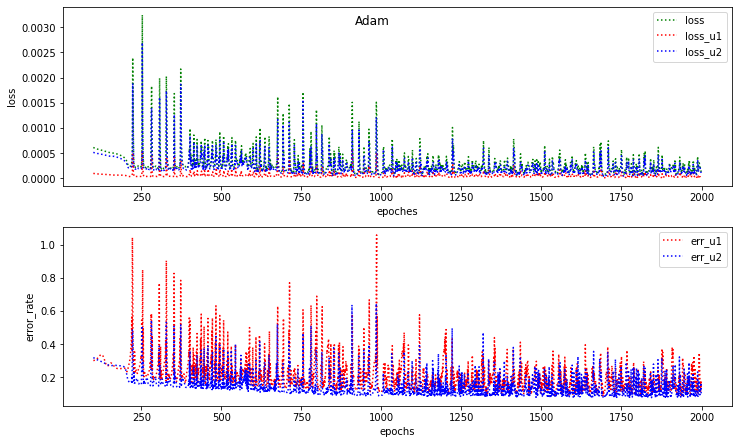

In [ ]:
fig = plot_Adam_history(history_saw_cp_4,start_epoch=0.05)

In [ ]:
func = function_factory(saw_couple_model, saw_couple_model.loss_Total,
              (X_u1_train,X_u2_train), (u1_train,u2_train), (X_f1_train,X_f2_train), X_i_train )

In [ ]:
params_1d = tf.dynamic_stitch(func.idx, saw_couple_model.trainable_variables[:])
## L-BFGS 优化阶段
max_iterations = 2000
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func,
    initial_position=params_1d, 
    num_correction_pairs=20, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    tolerance = 1*np.finfo(float).eps,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=max_iterations)
saw_couple_model.save_weights("./ModelData/saw_couple_model_inverse_R/weights")

In [ ]:
saw_couple_model.evaluate(ds_test)

5/5 [==============================] - 0s 18ms/step - err_u1: 0.0994 - err_u2: 0.0628


[0.09942567348480225, 0.06279971450567245]

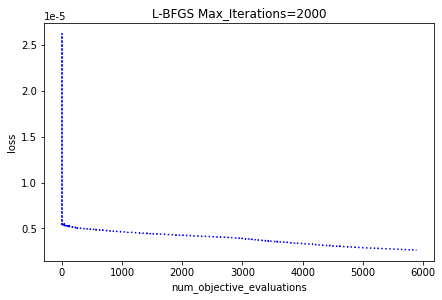

In [ ]:
fig_lbfgs = plot_Lbfgs_history(func.loss_history,max_iterations=max_iterations)

In [ ]:
""" 区域反问题  
regions_x = [[0.1,0.35],[0.4,0.65],[0.8,0.95]]
regions_y = [[0.1,0.35],[0.4,0.65],[0.7,0.9]]
regions_z = [[0.0,0.55],[0.6,0.95]]

regions_x = [[0.1,0.35],[0.4,0.65],[0.8,0.95]]
regions_y = [[0.1,0.35],[0.4,0.65],[0.7,0.9]]
regions_z = [[-0.95,-0.6],[-0.55,-0.1]]
"""
# Get more X_f_train Points near to boundary
X1_plus = [ [0.0,0.1],[0.95,1.0] ]
Y1_plus = [ [0.0,0.1],[0.9,1.0] ]
Z1_plus = [ [0.95,1.0]]
X_f1_plus = []

num_plus = 500
for x_plus in Y1_plus:
  for y_plus in Y1_plus:
    for z_plus in Z1_plus:
      lb = np.array([x_plus[0],y_plus[0],z_plus[0],0.0])
      ub = np.array([x_plus[1],y_plus[1],z_plus[1],1.0])
      X_f1_plus.append(lb + (ub-lb)*lhs(4,num_plus))
X_f1_plus = np.vstack(X_f1_plus)
X_f1_train_plus = np.vstack([X_f1_train,X_f1_plus])

X2_plus = [ [0.0,0.1],[0.95,1.0] ]
Y2_plus = [ [0.0,0.1],[0.9,1.0] ]
Z2_plus = [ [-1.0,-0.95],[-0.1,0.0] ]
X_f2_plus = []

num_plus = 500
for x_plus in Y2_plus:
  for y_plus in Y2_plus:
    for z_plus in Z2_plus:
      lb = np.array([x_plus[0],y_plus[0],z_plus[0],0.0])
      ub = np.array([x_plus[1],y_plus[1],z_plus[1],1.0])
      X_f2_plus.append(lb + (ub-lb)*lhs(4,num_plus))
X_f2_plus = np.vstack(X_f2_plus)
X_f2_train_plus = np.vstack([X_f2_train,X_f2_plus])

In [ ]:
func_plus = function_factory(saw_couple_model, saw_couple_model.loss_Total,
              (X_u1_train,X_u2_train), (u1_train,u2_train), (X_f1_train_plus,X_f2_train_plus), X_i_train )

In [ ]:
params_1d = tf.dynamic_stitch(func_plus.idx, saw_couple_model.trainable_variables[:])
## L-BFGS 优化阶段
max_iterations = 2000
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func_plus,
    initial_position=params_1d, 
    num_correction_pairs=20, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    tolerance = 1*np.finfo(float).eps,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=max_iterations)
saw_couple_model.save_weights("./ModelData/saw_couple_model_inverse_R/weights")

In [ ]:
saw_couple_model.load_weights("./saw_couple_model_inverse_R/weights")
saw_couple_model.evaluate(ds_test)

5/5 [==============================] - 0s 15ms/step - err_u1: 0.0689 - err_u2: 0.0515


[0.06887487322092056, 0.05147215723991394]

# Plotting

In [ ]:
""" Plot Data """
N = 20
X_u1,Y_u1,Z_u1,T_u1,U1 = plot_real_data(N,omga1,u1,t=1.0)
X_u2,Y_u2,Z_u2,T_u2,U2 = plot_real_data(N,omga2,u2,t=1.0)

U1_pred = plot_pred_data(X_u1,Y_u1,Z_u1,T_u1,model_u1)
U2_pred = plot_pred_data(X_u2,Y_u2,Z_u2,T_u2,model_u2)

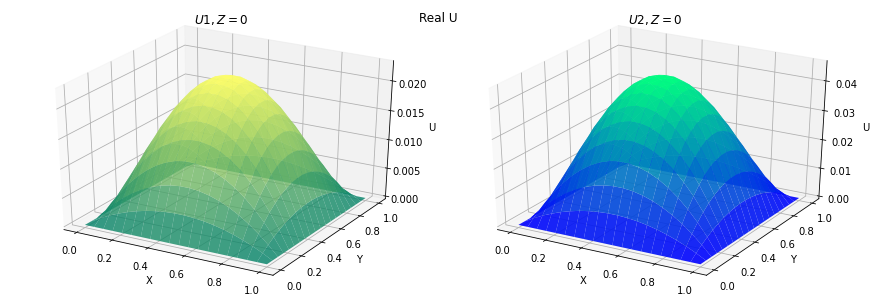

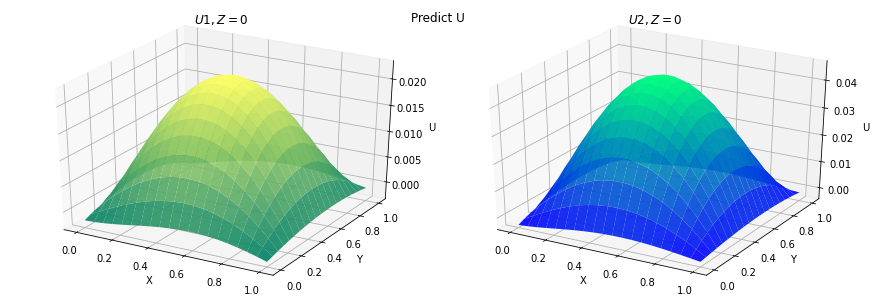

In [ ]:
####################################################
fig1=plt.figure(figsize=(12, 4)) 
fig1.suptitle("Real U")
ax11 = fig1.add_subplot(121,projection='3d')
ax11.plot_surface(X_u1[:,:,0],Y_u1[:,:,0],U1[:,:,0],alpha=0.8,cmap='summer')
#ax11.plot_surface(X_u1[:,:,5],Y_u1[:,:,5],Z_u1[:,:,5],facecolors=plt.cm.Oranges(U1[:,:,5]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调
#ax11.plot_surface(X_u1[:,:,-1],Y_u1[:,:,-1],Z_u1[:,:,-1],facecolors=plt.cm.Oranges(U1[:,:,-1]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调

#ax11.plot_surface(X_u1[:,0,:],Y_u1[:,0,:],Z_u1[:,0,:],facecolors=plt.cm.Oranges(U1[:,0,:]),alpha=0.8,) #alpha调节透明度，cmap调节曲面色调
#ax11.plot_surface(X_u1[:,-1,:],Y_u1[:,-1,:],Z_u1[:,0,:],facecolors=plt.cm.Oranges(U1[:,-1,:]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调

#ax11.plot_surface(X_u1[0,:,:],Y_u1[0,:,:],Z_u1[0,:,:],facecolors=plt.cm.Oranges(U1[0,:,:]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调
#ax11.plot_surface(X_u1[-1,:,:],Y_u1[-1,:,:],Z_u1[0,:,:],facecolors=plt.cm.Oranges(U1[-1,:,:]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调

ax12 = fig1.add_subplot(122,projection='3d')
ax12.plot_surface(X_u2[:,:,-1],Y_u2[:,:,-1],U2[:,:,-1],alpha=0.9,cmap='winter')

ax11.set_xlabel("X")   
ax11.set_ylabel("Y")
ax11.set_zlabel("U")
ax11.set_title("$U1,Z=0$")

ax12.set_xlabel("X")   
ax12.set_ylabel("Y")
ax12.set_zlabel("U")
ax12.set_title("$U2,Z=0$")
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
fig1.savefig("3d_parabolic_surface_u1.png")
###################################################### 
fig2 = plt.figure(figsize=(12, 4)) 
fig2.suptitle("Predict U")
ax21 = fig2.add_subplot(121,projection="3d")
ax22 = fig2.add_subplot(122,projection="3d")

### u1
ax21.plot_surface(X_u1[:,:,0],Y_u1[:,:,0],U1_pred[:,:,0],alpha=0.9,cmap='summer')
ax21.set_xlabel("X")   
ax21.set_ylabel("Y")
ax21.set_zlabel("U")
ax21.set_title("$U1,Z=0$")

### u2
ax22.plot_surface(X_u2[:,:,-1],Y_u2[:,:,-1],U2_pred[:,:,-1],alpha=0.9,cmap='winter')

ax22.set_xlabel("X")   
ax22.set_ylabel("Y")
ax22.set_zlabel("U")
ax22.set_title("$U2,Z=0$")
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
fig2.savefig("3d_parabolic_surface_u2_inverse_R.png")
###############################

plt.show()

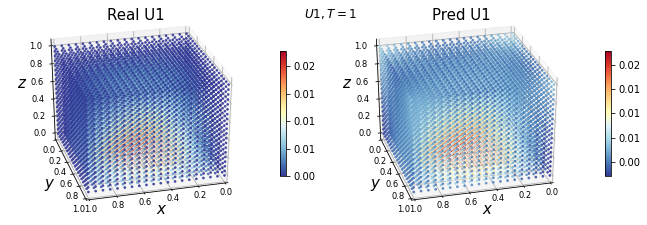

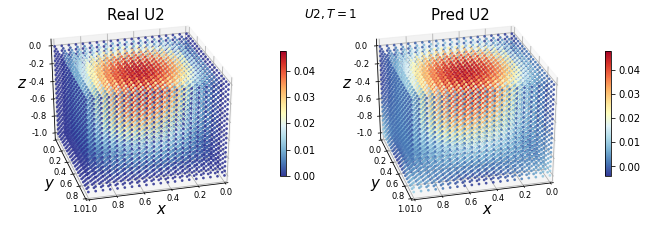

In [ ]:
u1_3D_data_dict = {
  'Real U1':[X_u1,Y_u1,Z_u1,U1],
  'Pred U1':[X_u1,Y_u1,Z_u1,U1_pred],
}
u2_3D_data_dict = {
  'Real U2':[X_u2,Y_u2,Z_u2,U2],
  'Pred U2':[X_u2,Y_u2,Z_u2,U2_pred],
}
fig1 = plot3D_scatter(u1_3D_data_dict,colN = 2)
fig1.suptitle("$U1,T=1$")
fig1.savefig("3d_parabolic_scatter_u1_inverse_R.png")
fig2 = plot3D_scatter(u2_3D_data_dict,colN = 2)
fig2.suptitle("$U2,T=1$")
fig2.savefig("3d_parabolic_scatter_u2_inverse_R.png")
plt.show()

# Save Model

In [ ]:
saw_couple_model.save_weights("./ModelData/saw_couple_model_inverse_R/weights")